# Creating NLP Word Embeddings with PyTorch

In [1]:
# https://stackoverflow.com/questions/50747947/embedding-in-pytorch
# https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

from IPython.display import clear_output
import time

In [3]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
#import mpld3
#mpld3.enable_notebook()
#!pip install --user "git+https://github.com/javadba/mpld3@display_fix"

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import nltk
from nltk.corpus import gutenberg
import re
from collections import Counter # collections library; counter: dict subclass for counting hashable objects

In [8]:
from nlp_labs.utils import my_sentence_tokenizer, get_all_tokens, encode_sentence

## Load and Preprocess Corpus

In [9]:
tag_start = '<s>'
tag_end = '</s>'
tag_oov = '<unk>'
tag_pad = '<pad>'

tags = dict({'tag_start':tag_start, 'tag_end':tag_end,'tag_oov':tag_oov, 'tag_pad':tag_pad})

max_len_sentence = 13

In [10]:
corpus = gutenberg.words('melville-moby_dick.txt') # 'melville-moby_dick.txt' 'shakespeare-hamlet.txt'
print(type(corpus),len(corpus))
corpus_str = ' '.join(corpus)

#with open("./data/wiki_sample_corpusdataorg.txt", "rb") as f:
#    txt = f.readlines()
#corpus_str = ''.join([s.decode('utf-8') for s in txt])



print(type(corpus_str),len(corpus_str))
corpus_str = re.sub(r'[,!?;-]+', '.', corpus_str) # clean punctuation

doc = my_sentence_tokenizer(corpus_str,tag_start,tag_end)
tokens = get_all_tokens(doc)

n_print = 100
print(f'After cleaning:  {len(tokens)} tokens, first {n_print}  {tokens[:n_print]}')

# create vocab including word count using collections.Counter
word_count_vocab = dict()
word_count_vocab = Counter(tokens)

word_count_vocab.pop(tag_start)
word_count_vocab.pop(tag_end)

print(word_count_vocab.most_common(10))
print('count : ',len(word_count_vocab))

vocabulary = list(enumerate(sorted(set(word_count_vocab.keys())),start=4))

for i, tag in enumerate(list(tags.values())):
    vocabulary.insert(i,(i,tag))
print(vocabulary[:10]) # sorted vocabulary

idx2word = dict(vocabulary)
list(idx2word.items())[0:10]

word2idx = dict({k:v for v, k in idx2word.items()})
list(word2idx.items())[:10]

coded_corpus = [encode_sentence(s,word2idx, max_len_sentence=max_len_sentence,
                               tag_oov=tag_oov, tag_pad=tag_pad) for s in doc]

print(coded_corpus[202])
print(len(coded_corpus))

S = len(coded_corpus)           
T = len(coded_corpus[0]) # max_len_sentence + 2
V = len(word2idx)  

<class 'nltk.corpus.reader.util.StreamBackedCorpusView'> 260819
<class 'str'> 1259862
After cleaning:  330684 tokens, first 100  ['<s>', 'moby', 'dick', 'by', 'herman', 'melville', 'etymology', '.', '</s>', '<s>', 'supplied', 'by', 'a', 'late', 'consumptive', 'usher', 'to', 'a', 'grammar', 'school', 'the', 'pale', 'usher', '.', '</s>', '<s>', 'threadbare', 'in', 'coat', '.', '</s>', '<s>', 'heart', '.', '</s>', '<s>', 'body', '.', '</s>', '<s>', 'and', 'brain', '.', '</s>', '<s>', 'i', 'see', 'him', 'now', '.', '</s>', '<s>', 'he', 'was', 'ever', 'dusting', 'his', 'old', 'lexicons', 'and', 'grammars', '.', '</s>', '<s>', 'with', 'a', 'queer', 'handkerchief', '.', '</s>', '<s>', 'mockingly', 'embellished', 'with', 'all', 'the', 'gay', 'flags', 'of', 'all', 'the', 'known', 'nations', 'of', 'the', 'world', '.', '</s>', '<s>', 'he', 'loved', 'to', 'dust', 'his', 'old', 'grammars', '.', '</s>', '<s>', 'it']
[('.', 37440), ('the', 14431), ('of', 6609), ('and', 6430), ('a', 4736), ('to', 4625

In [11]:
S, T, V

(37407, 15, 16952)

In [12]:
coded_corpus_np = np.array(coded_corpus)
coded_corpus_np.shape

(37407, 15)

In [13]:
def get_context(coded_sentence, context_size,word2idx, tags, T):
    
    # end_position = np.where(coded_sentence==word2idx[tags['tag_end']])[0].item()
    # apesar de quebrar a frase na hora certa, gera um problema de batches de tamanhos diferentes
    
    end_position = T
    
    target_context = []
    for pos in range(0,end_position):
        middle_word   = coded_sentence[pos]

        left_start = max(pos-context_size,0)
        right_end  = min(pos+1+context_size,end_position)

        if pos - left_start < context_size:                # first words position
            right_end += context_size-(pos-left_start)     # --> increse right_context size
        elif right_end-(pos+1) < context_size:             # last words position
            left_start -= context_size-(right_end-(pos+1)) # --> increase left_context size

        left_context  = coded_sentence[left_start:pos]
        right_context = coded_sentence[pos+1:right_end]
        
        
        context       = left_context + right_context # list concatenation

        target_context.append((middle_word,context))
    return target_context

In [14]:
def get_batches(coded_corpus, batch_size, half_context_size, S, T, V, word2idx, tags):
    i = 0
    while True:
        sentences = coded_corpus[i:i+batch_size]
        X = []
        Y = []
        for s in sentences:
            for y, x in get_context(s, half_context_size, word2idx, tags, T):
                X.append(x)
                Y.append(y)
        yield (np.array(X), np.array(Y).reshape(-1,1))
        
        i += batch_size
        if i >= S-batch_size:
            print('i is being set to 0')
            i = 0

In [15]:
def get_train_vectors(context_batches, middle_word_batches):
    X_train = np.zeros(shape=(batch_size*T,V))
    #Y_train = np.zeros(shape=(batch_size*T,V))
    Y_train = np.zeros(shape=(batch_size*T))
    
    for context_id in range(context_batches.shape[0]):
        context     = context_batches[context_id]
        middle_word = middle_word_batches[context_id].item()
        for cw in  context:
            weight = 1 if word_count_vocab[idx2word[cw]] else 0
            X_train[context_id, cw] += weight/(2*half_context_size)
        
        # Y_train[context_id, middle_word] = 1
        Y_train[context_id] = middle_word
    return (torch.FloatTensor(X_train), torch.LongTensor(Y_train))
# X_train[np.where(X_train)]

In [16]:
batch_size = 2
half_context_size = 2
batch_generator = get_batches(coded_corpus=coded_corpus, 
                              batch_size=batch_size, half_context_size=half_context_size, 
                              S=S, T=T, V=V, word2idx=word2idx, tags=tags)

In [17]:
X, Y  = next(batch_generator)
X.shape, Y.shape, (batch_size)*T
#print(np.concatenate((X, Y),axis=1))

((30, 4), (30, 1), 30)

# Training the Embeddings with Language Model

## Continuous Bag-of-Words (CBOW)

context vs target

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints about PyTorch input layer format</b></font>
</summary>

[from here](https://discuss.pytorch.org/t/confused-about-tensor-dimensions-and-batches/4761/2)

    
> The input to a linear layer should be a tensor of size [batch_size, input_size] where input_size is the same size as the first layer in your network (so in your case it’s num_letters).  
    The problem appears in the line:  
    `tensor = torch.zeros(len(name), 1, num_letters)`  
    which should actually just be:  
    `tensor = torch.zeros(len(name), num_letters)`

> As an easy example:  
> ```python
        input_size = 8
        output_size = 14
        batch_size = 64
        net = nn.Linear(input_size, output_size)  
        input = Variable(torch.FloatTensor(batch_size, input_size))  
        output = net(input)  
        print("Output size:", output.size())
    
> ```CPP
    Output size: (64, 14)
    

> Hope this helps,  
  Jordan
</p>



In [18]:
class Language_Model_w2v(nn.Module):
    
    def __init__(self, vocab_size, num_of_dimensions_of_embedding):
        super(Language_Model_w2v, self).__init__()
        self.V  = vocab_size
        self.N  = num_of_dimensions_of_embedding 
        
        self.W1  = nn.Linear(self.V, self.N)
        self.H1  = nn.ReLU(inplace=True)
        
        self.Winv = nn.Linear(self.N, self.V)
        self.LogSoftMax = nn.LogSoftmax(dim=1)
        
        # self.layers = nn.Sequential(*[self.e, self.W1, self.W2,self.LogSoftMax])
        
    def forward(self,x):              
        x = self.H1(self.W1(x))
        x = self.LogSoftMax(self.Winv(x))
        
        return x

In [19]:
max_epochs = 2
batch_size = 200
max_batch_iters = np.floor(S/batch_size)

Nd = 100
half_context_size = 4

batch_generator = get_batches(coded_corpus=coded_corpus, 
                              batch_size=batch_size, half_context_size=half_context_size, 
                              S=S, T=T, V=V, word2idx=word2idx, tags=tags)

print_iters = 10

losses    = []
criterion = nn.NLLLoss()
model     = Language_Model_w2v(vocab_size=V, num_of_dimensions_of_embedding=Nd)
optimizer = optim.Adam(model.parameters(), lr=7e-4) # optim.SGD(model.parameters(),lr=1e-2) #  #   # 

In [20]:
model

Language_Model_w2v(
  (W1): Linear(in_features=16952, out_features=100, bias=True)
  (H1): ReLU(inplace=True)
  (Winv): Linear(in_features=100, out_features=16952, bias=True)
  (LogSoftMax): LogSoftmax()
)

In [21]:
max_batch_iters

187.0

In [22]:
batch_losses = []
for epoch in range(max_epochs):
    
    cnt = 0
    
    # coded_sentences = coded_sentences[:,np.random.permutation(S)]
    
    for X, Y in batch_generator:
    
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words into integer indices and wrap them in tensors)
        X_train, Y_train = get_train_vectors(context_batches=X, middle_word_batches = Y)
        
        # Step 2. Recall that torch *accumulates* gradients. 
        # Before passing in a new instance, you need to zero out the gradients from the oldinstance
        model.zero_grad()
            
        # Step 3. Run the forward pass, getting log probabilities over next words
        log_probs = model(X_train)  
            
        # Step 4. Compute your loss function. 
        # (Again, Torch wants the target word wrapped in a tensor)
        loss = criterion(log_probs, Y_train.T)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        # total_loss += loss.item()
        
        batch_losses.append(loss)
        
        
        if cnt%print_iters==1:
            print(f'epoch {epoch} sentence {cnt*batch_size}/{S} loss: {loss.item():.5f}')
            
        cnt+=1
            
        if cnt>=max_batch_iters:
            break
    
    #time.sleep(1.5)
    #clear_output()
#print(losses)  # The loss decreased every iteration over the training data!

epoch 0 sentence 200/37407 loss: 9.76057
epoch 0 sentence 2200/37407 loss: 9.73403
epoch 0 sentence 4200/37407 loss: 9.70723
epoch 0 sentence 6200/37407 loss: 9.66506
epoch 0 sentence 8200/37407 loss: 9.60799
epoch 0 sentence 10200/37407 loss: 9.53666
epoch 0 sentence 12200/37407 loss: 9.44488
epoch 0 sentence 14200/37407 loss: 9.33934
epoch 0 sentence 16200/37407 loss: 9.19838
epoch 0 sentence 18200/37407 loss: 9.02305
epoch 0 sentence 20200/37407 loss: 8.83608
epoch 0 sentence 22200/37407 loss: 8.63199
epoch 0 sentence 24200/37407 loss: 8.41055
epoch 0 sentence 26200/37407 loss: 8.13377
epoch 0 sentence 28200/37407 loss: 7.83277
epoch 0 sentence 30200/37407 loss: 7.58087
epoch 0 sentence 32200/37407 loss: 7.28294
epoch 0 sentence 34200/37407 loss: 6.98696
epoch 0 sentence 36200/37407 loss: 6.65421
i is being set to 0
epoch 1 sentence 200/37407 loss: 6.55069
epoch 1 sentence 2200/37407 loss: 6.20869
epoch 1 sentence 4200/37407 loss: 5.96030
epoch 1 sentence 6200/37407 loss: 5.64348
ep

In [23]:
X_train.shape

torch.Size([3000, 16952])

In [24]:
batch_losses_np = np.array([loss.detach() for loss in batch_losses])

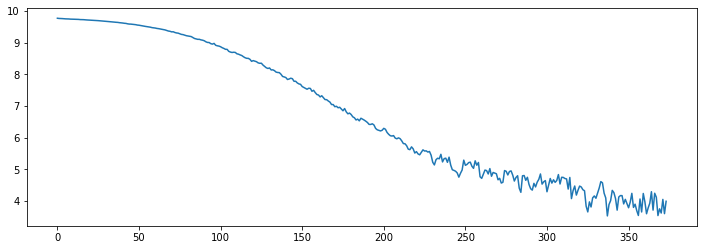

In [25]:
plt.figure(figsize=(12,4))

plt.plot(batch_losses_np)
plt.show();

In [26]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape) # param.data

W1.weight torch.Size([100, 16952])
W1.bias torch.Size([100])
Winv.weight torch.Size([16952, 100])
Winv.bias torch.Size([16952])


In [53]:
Embedding = 1/2*(model.Winv.weight.data + model.W1.weight.data.T)
Embedding.shape, Embedding

(torch.Size([16952, 100]),
 tensor([[ 0.1294,  0.0987, -0.0093,  ..., -0.0124, -0.0029,  0.0127],
         [ 0.0820,  0.1265, -0.0016,  ...,  0.0171,  0.0218, -0.0268],
         [-0.1638, -0.1563,  0.0012,  ..., -0.0271, -0.0374, -0.0172],
         ...,
         [-0.0497, -0.0550,  0.0391,  ..., -0.0505, -0.0113, -0.0265],
         [-0.0988, -0.1464, -0.0125,  ..., -0.0295,  0.0454, -0.0154],
         [-0.1210, -0.1383,  0.0444,  ..., -0.0087,  0.0376,  0.0473]]))

In [54]:
def word_analogy(pos_neg_1=('king','man'),pos_neg_2=('queen','woman'), n_closest = 4, word2idx=None, idx2word=None):
    king_w,    man_w = pos_neg_1
    queen_w, woman_w = pos_neg_2
    
    for w in (king_w,man_w,woman_w):
        if w not in word2idx:
            raise Exception(f'sorry, word "{w}" not in dictionary.')
    
    print(f'Expected: {king_w} - {man_w} = {queen_w} - {woman_w}')
    
    king   = word2idx[king_w]
    man    = word2idx[man_w]
    woman  = word2idx[woman_w]
    
    vec = (Embedding[king] - Embedding[man] + Embedding[woman]).view(1,-1) # Embedding[queen]
    distances = pairwise_distances(vec.reshape(1, -1), Embedding, metric='cosine').reshape(V)
    
    idx = distances.argsort()[:n_closest+3] 
    idx = [x for x in idx if x not in set([man,king,woman])]
    queen_estimated = idx2word[idx[0]]
    
    print(f'Got:      {king_w} - {man_w} = {queen_estimated} - {woman_w}')
    
    print(f'Closest {len(idx)} words:')
    for i in idx:
        print(f'{idx2word[i]}')

In [55]:
w1 = 'king'
w2 = 'man'
w3 = 'queen'
w4 = 'woman'

word_analogy(pos_neg_1=(w1,w2),pos_neg_2=(w3,w4), n_closest = 4, word2idx=word2idx, idx2word=idx2word)

Expected: king - man = queen - woman
Got:      king - man = reigneth - woman
Closest 7 words:
reigneth
establishing
arguments
transit
frosted
speculative
epicurean


In [56]:
w1 = 'man'
w2 = 'woman'
w3 = 'he'
w4 = 'she'

word_analogy(pos_neg_1=(w1,w2),pos_neg_2=(w3,w4), n_closest = 4, word2idx=word2idx, idx2word=idx2word)

Expected: man - woman = he - she
Got:      man - woman = it - she
Closest 6 words:
it
and
in
a
<s>
then


In [57]:
w1 = 'man'
w2 = 'woman'
w3 = 'husband'
w4 = 'wife'

word_analogy(pos_neg_1=(w1,w2),pos_neg_2=(w3,w4), n_closest = 4, word2idx=word2idx, idx2word=idx2word)

Expected: man - woman = husband - wife
Got:      man - woman = it - wife
Closest 6 words:
it
and
for
the
of
so


In [58]:
w1 = 'boy'
w2 = 'man'
w3 = 'girl'
w4 = 'woman'

word_analogy(pos_neg_1=(w1,w2),pos_neg_2=(w3,w4), n_closest = 4, word2idx=word2idx, idx2word=idx2word)

Expected: boy - man = girl - woman
Got:      boy - man = underlings - woman
Closest 7 words:
underlings
intricacy
founder
dismantled
counsellors
characterizing
slogan


In [59]:
w1 = 'i'
w2 = 'me'
w3 = 'he'
w4 = 'his'

word_analogy(pos_neg_1=(w1,w2),pos_neg_2=(w3,w4), n_closest = 4, word2idx=word2idx, idx2word=idx2word)

Expected: i - me = he - his
Got:      i - me = and - his
Closest 5 words:
and
a
that
but
it


In [60]:
w1 = 'prince'
w2 = 'king'
w3 = 'princess'
w4 = 'queen'

word_analogy(pos_neg_1=(w1,w2),pos_neg_2=(w3,w4), n_closest = 4, word2idx=word2idx, idx2word=idx2word)

Expected: prince - king = princess - queen
Got:      prince - king = scornfully - queen
Closest 6 words:
scornfully
exasperate
timberheads
rechurned
assistants
playfully


In [61]:
# word_count_vocab

# PCA Visualization of Word-Analogy

In [62]:
from sklearn.decomposition import PCA

In [63]:
pca = PCA(n_components=2)
pca.fit(Embedding)
Embedding_2D = pca.transform(Embedding)

In [64]:
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label

In [65]:
p = figure()

# output to static HTML file
output_file("embeeded_word_vectors_pca.html")

Nplot = 2500

most_common_words = [word2idx[x[0]] for x in word_count_vocab.most_common(Nplot)]

p.scatter(x=Embedding_2D[most_common_words,0], y=Embedding_2D[most_common_words,1])

for i in most_common_words:
    my_text = Label(text=idx2word[i], x=Embedding_2D[i,0],y=Embedding_2D[i,1])
    p.add_layout(my_text)
    
show(p)